#Importing necessary libraries

---



In [ ]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet

from sklearn.metrics import mean_squared_error,mean_absolute_error
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')


#***Data Loading and Initial Exploration***

---



We begin by loading the dataset and examining the initial few rows to understand its structure.

In [ ]:
# Set plotting styles
plt.style.use('ggplot')
plt.style.use('fivethirtyeight')
# Define function to calculate Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true,y_pred):
    """Calculate MAPE given by y_true and y_pred"""
    y_true,y_pred=np.array(y_true),np.array(y_pred)
    return np.mean(np.abs((y_true-y_pred)/y_true))*100

In [ ]:
# Load the dataset
data=pd.read_csv('modified_working_data.csv')
# Display the first few rows of the dataset
data.head()

,SubCounty,class,Year,PermitNo,ServiceHeaderID,DATE,CustomerName,pin,ServiceName,Amount,IssuedBy,BusinessActivity,Service Code,Ward,PhysicalLocation,DayOfWeek,Month,Column1,LogAmount,frequency
0,Kesses,micro,2023,AVJK14WGU0,2846320,06/11/2023,BERUR CHEMIST,A010342075J,723-Health Institutions/Services Health clinic...,4000.0,NANCY J KEMEI,CHEMIST,723,TULWET-CHUIYAT,"Building: TALA BUSINESS CENTRE, Floor: GROUND...",0,11,NaN,8.294300,1.0
1,Moiben,micro,2023,XZVT4NOA02,2846146,03/11/2023,TYCOON MWANGI,A018655361F,113-Small Boutique less than 2 employees and l...,2000.0,WIBERFORCE J WABUKO,BOUTIQUE,113,Kimumu,"Building: N/A, Floor: GROUND FLOOR, Room: 1, R...",4,11,NaN,7.601402,1.0
2,SOY,micro,2023,1RZG3FWC5E,2846220,03/11/2023,CORNER PUB,A014102776K,567-Small Bar/Traditional Beer Seller up to 15...,4000.0,boaz kiprotich,SMALL BAR,567,Ziwa,"Building: CORNER HSE, Floor: 0, Room: 0, Road:",4,11,NaN,8.294300,1.0
3,Turbo,micro,2023,W5E30PJG4H,2791569,02/11/2023,KEJU,A003889655V,647-KINYOZI/SALON Small,3400.0,RICHARD AMDANY,KINYOZI / SALON,647,Ngenyilel,"Building: KEJU, Floor: 1, Room: 2, Road:",3,11,NaN,8.131825,1.0
4,Turbo,micro,2023,280RSZQCJE,2845836,02/11/2023,EDDIESCAPES POWER ENGINEERING SOLUTIONS COMPAN...,P052271153R,695-Other professional and technical services,3400.0,WABWIRE SIMIYU DAVID,"ELECTRICAL INSTALLATIONS,CONSULTANCY & SUPPLIES",695,Kiplombe,"Building: N/A, Floor: GROUND FLOOR, Room: 1, R...",3,11,NaN,8.131825,1.0


In [ ]:
data.head()

,class,DATE,Amount
0,micro,06/11/2023,4000.0
1,micro,03/11/2023,2000.0
2,micro,03/11/2023,4000.0
3,micro,02/11/2023,3400.0
4,micro,02/11/2023,3400.0


#***Data Grouping and Saving***


---


The data is grouped by the "class" column, and each group is saved into separate CSV files.

In [ ]:
# Group the dataset by the "class" column
grouped = data.groupby("class")

# Iterate over each group
for group_name, group_data in grouped:
    # Define the filename for this group
    filename = f"{group_name}.csv"

    # Save the group data to a CSV file
    group_data.to_csv(filename, index=False)


#***Micro Class Data Preparation***

---



We proceed with the 'micro' class data for our analysis:




In [ ]:
# Load the 'micro' class dataset
df=pd.read_csv('micro.csv')
# Display dataset summary
df.describe()

,Amount
count,31378.000000
mean,3274.726560
std,799.540302
min,520.000000
25%,2800.000000
50%,3400.000000
75%,4000.000000
max,4000.000000


In [ ]:
# Convert DATE column to datetime format
df['DATE'] = pd.to_datetime(df['DATE'], dayfirst=True).dt.strftime('%Y-%m-%d')


In [ ]:
# Drop the 'class' column
df.drop(columns='class')

,DATE,Amount
0,2023-11-06,4000.0
1,2023-11-03,2000.0
2,2023-11-03,4000.0
3,2023-11-02,3400.0
4,2023-11-02,3400.0
...,...,...
31373,2016-03-01,2000.0
31374,2016-03-01,4000.0
31375,2016-02-27,3400.0
31376,2016-02-26,2000.0


In [ ]:
# Set DATE as the index
df.set_index('DATE', inplace=True)

In [ ]:
# Sort the dataset by index (DATE)
df.sort_index(inplace=True)


#***Outlier Detection and Cleaning***

Using box plots and statistical methods, we check and handle outliers:

<AxesSubplot: xlabel='Amount', ylabel='Density'>

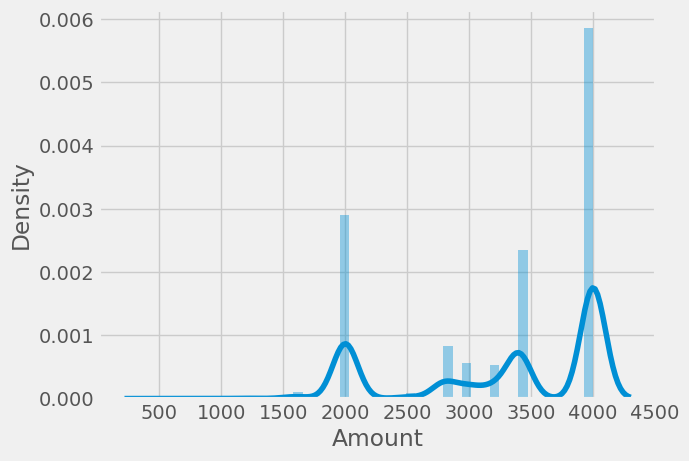

In [ ]:
# Plot distribution of the Amount column
sns.distplot(df['Amount'])

<AxesSubplot: ylabel='Amount'>

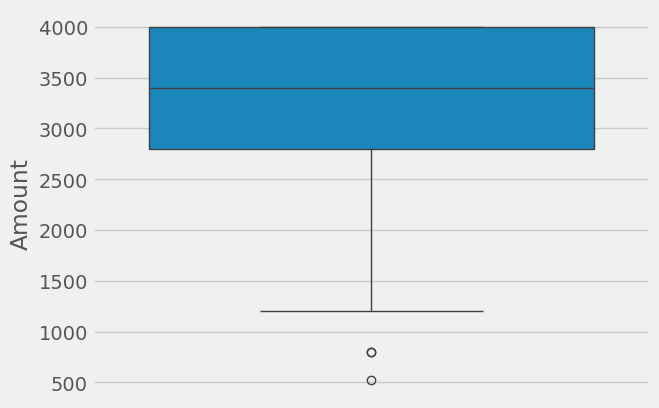

In [ ]:
# Plot a boxplot to detect outliers
sns.boxplot(y='Amount',data=df)

In [ ]:
df.describe()

,Amount
count,31378.000000
mean,3274.726560
std,799.540302
min,520.000000
25%,2800.000000
50%,3400.000000
75%,4000.000000
max,4000.000000


In [ ]:
# Define interquartile range (IQR) for outlier detection
Q1=2800
Q3=4000
IQR=Q3-Q1
lower_lim=Q1-1.5*IQR
upper_lim=Q3+1.5*IQR
lower_lim,upper_lim

(1000.0, 5800.0)

In [ ]:
# Print rows with outliers
df[(df.Amount<lower_lim)|(df.Amount>upper_lim)]

,class,Amount
DATE,,
2017-01-27,micro,800.0
2017-05-31,micro,800.0
2017-07-14,micro,520.0


In [ ]:
# Remove outliers from the dataset
new_df=df.loc[(df['Amount']>lower_lim)]
print('Old data:',len(df))
print('New data:',len(new_df))



Old data: 31378
New data: 31375


<AxesSubplot: ylabel='Amount'>

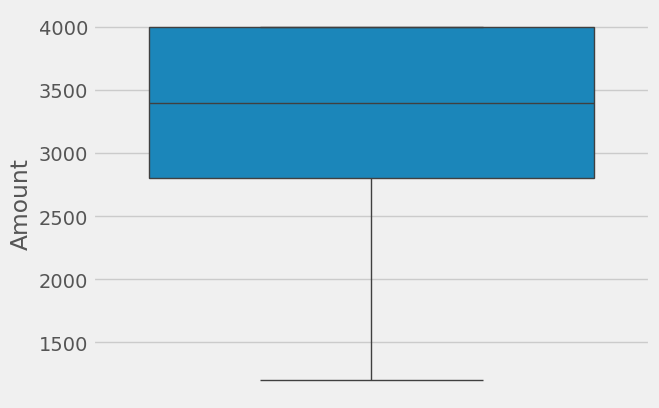

In [ ]:
# Plot boxplot for the cleaned dataset
sns.boxplot(y='Amount',data=new_df)

The data is clean and there are no outliers

In [ ]:
# Assign the cleaned data back to the original dataframe
new_df=df

#***Data Visualization***

Plotting the data to visualize trends and patterns:

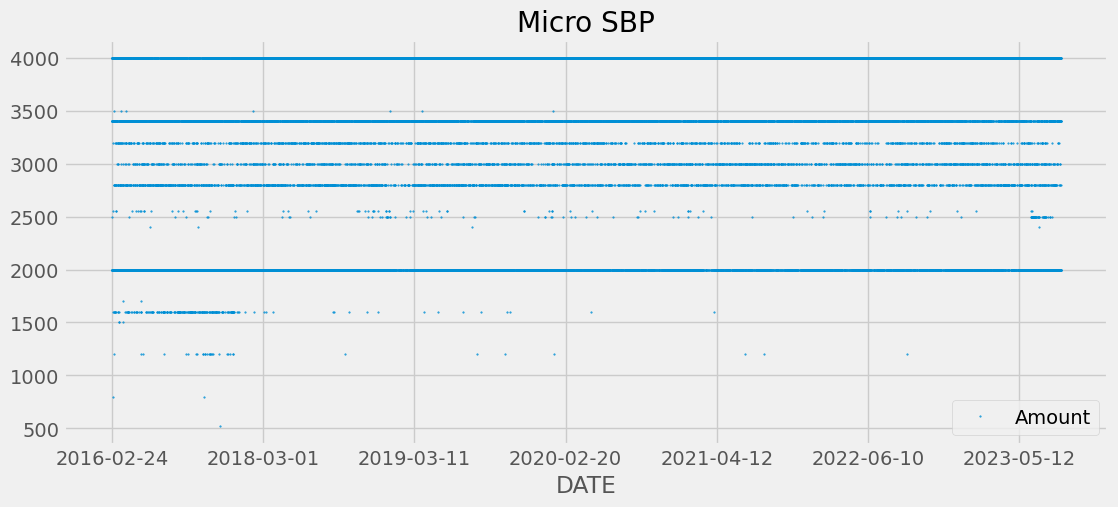

In [ ]:
# Plot the cleaned data
color_pal=sns.color_palette()
df.plot(style='.',figsize=(12,5),ms=1,color=color_pal[0],title='Micro SBP')
plt.show()

#***Train-Test Split***

Splitting the data into training and test sets based on a specified date:

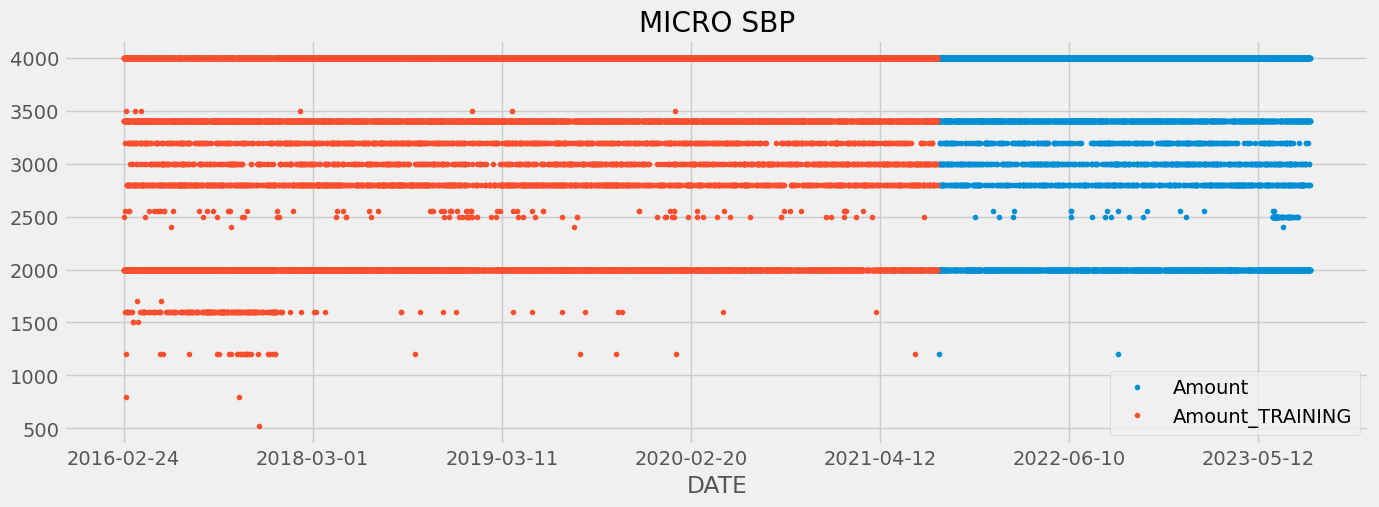

In [ ]:
# Split the dataset into training and test sets based on the split date
split_date='2021-06-09'
df_train=df.loc[df.index<=split_date].copy()
df_test=df.loc[df.index>split_date].copy()
# Rename columns for clarity
df_train.rename(columns={'SBP': 'TRAINING SET'}, inplace=True)
df_test.rename(columns={'SBP': 'TEST SET'}, inplace=True)

# Join the two DataFrames, specifying suffixes to avoid column overlap
df_combined = df_test.join(df_train, how='outer', rsuffix='_TRAINING')

# Plot the combined DataFrame
color_pal = sns.color_palette()
df_combined.plot(figsize=(15, 5), title='MICRO SBP', style='.', color=[color_pal[0], color_pal[1]])
plt.show()

#***Prophet Model Training***

---



Preparing the data for Prophet and fitting the model:

In [ ]:
# Reset index and rename columns for Prophet
df_train_prohet=df_train.reset_index()  \
    .rename(columns={'DATE':'ds','Amount':'y'})

In [ ]:
# Display first few rows of the training data for Prophet
df_train_prohet.head()

,ds,class,y
0,2016-02-24,micro,4000.0
1,2016-02-26,micro,2000.0
2,2016-02-27,micro,3400.0
3,2016-03-01,micro,4000.0
4,2016-03-01,micro,2000.0


In [ ]:
# Initialize and fit the Prophet model
model=Prophet()
model.fit(df_train_prohet)

13:11:55 - cmdstanpy - INFO - Chain [1] start processing
13:12:05 - cmdstanpy - INFO - Chain [1] done processing


#***Forecasting***

---



Using the Prophet model to forecast future values and visualize the results:

In [ ]:
# Prepare test data for Prophet model
df_test_prophet=df_test.reset_index()  \
    .rename(columns={'DATE':'ds','Amount':'y'})
df_test_prophet['ds'] = pd.to_datetime(df_test_prophet['ds'])
# Make predictions using the Prophet model
df_test_fcst=model.predict(df_test_prophet)

In [ ]:
# Display the forecasted values
df_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-06-10,3380.544593,2381.129916,4337.327119,3380.544593,3380.544593,-3.613011,-3.613011,-3.613011,41.29928,41.29928,41.29928,-44.912291,-44.912291,-44.912291,0.0,0.0,0.0,3376.931582
1,2021-06-10,3380.544593,2380.678502,4406.994469,3380.544593,3380.544593,-3.613011,-3.613011,-3.613011,41.29928,41.29928,41.29928,-44.912291,-44.912291,-44.912291,0.0,0.0,0.0,3376.931582
2,2021-06-10,3380.544593,2381.613952,4374.801004,3380.544593,3380.544593,-3.613011,-3.613011,-3.613011,41.29928,41.29928,41.29928,-44.912291,-44.912291,-44.912291,0.0,0.0,0.0,3376.931582
3,2021-06-10,3380.544593,2314.772677,4447.580221,3380.544593,3380.544593,-3.613011,-3.613011,-3.613011,41.29928,41.29928,41.29928,-44.912291,-44.912291,-44.912291,0.0,0.0,0.0,3376.931582
4,2021-06-10,3380.544593,2396.852058,4424.882536,3380.544593,3380.544593,-3.613011,-3.613011,-3.613011,41.29928,41.29928,41.29928,-44.912291,-44.912291,-44.912291,0.0,0.0,0.0,3376.931582


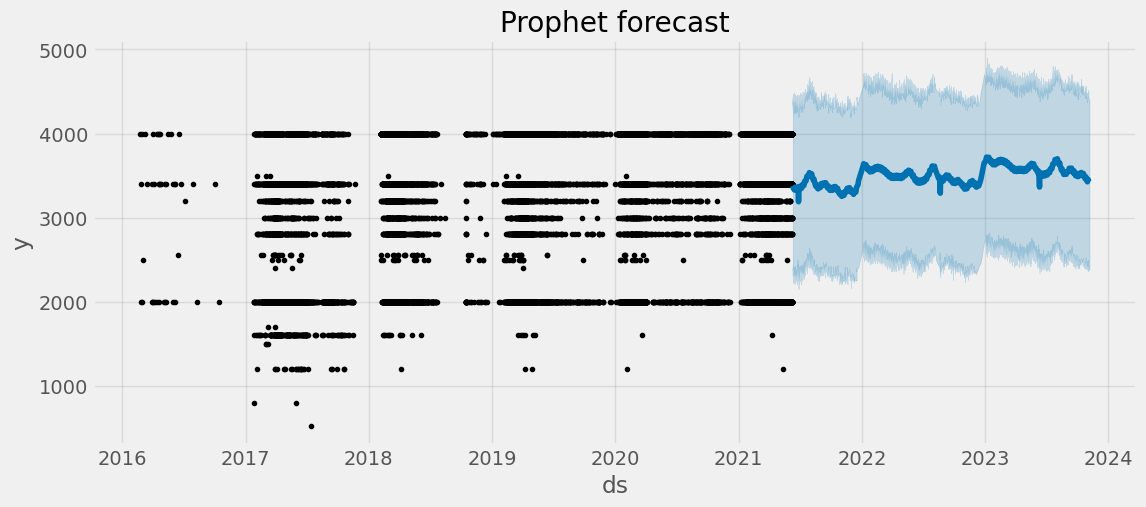

In [ ]:
# Plot the forecasted values
fig,ax=plt.subplots(figsize=(12,5))
fig=model.plot(df_test_fcst,ax=ax)
ax.set_title('Prophet forecast')
plt.show()

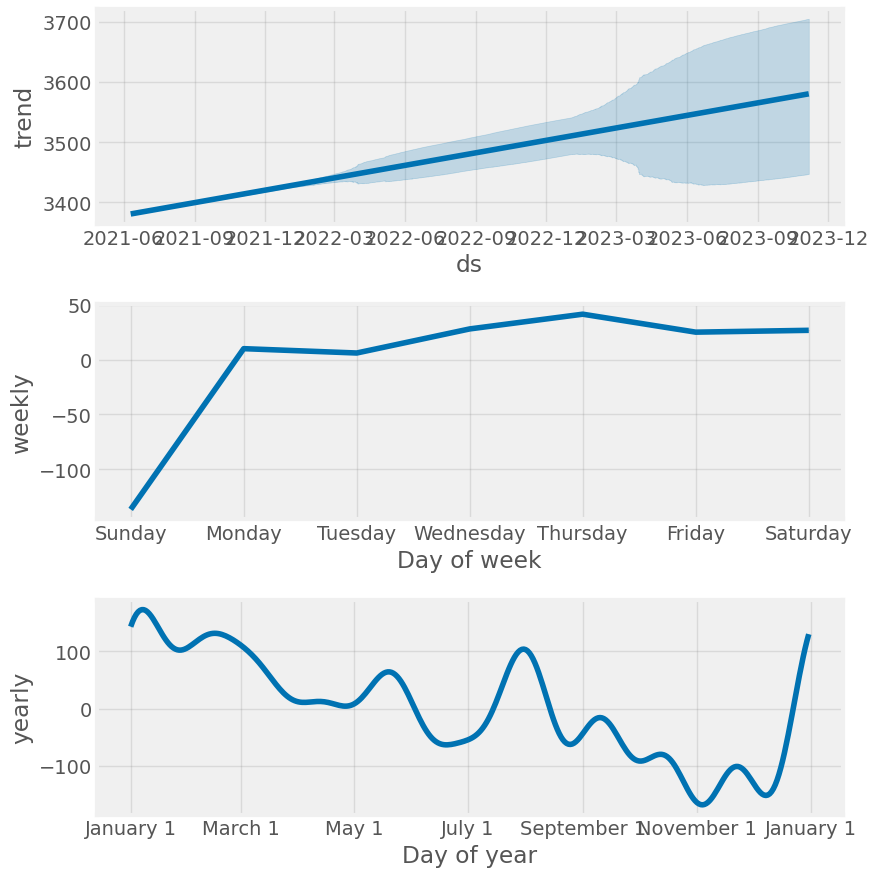

<Figure size 1600x500 with 0 Axes>

In [ ]:
# Plot the forecast components
fig=model.plot_components(df_test_fcst)
plt.figure(figsize=[16, 5])
plt.show()

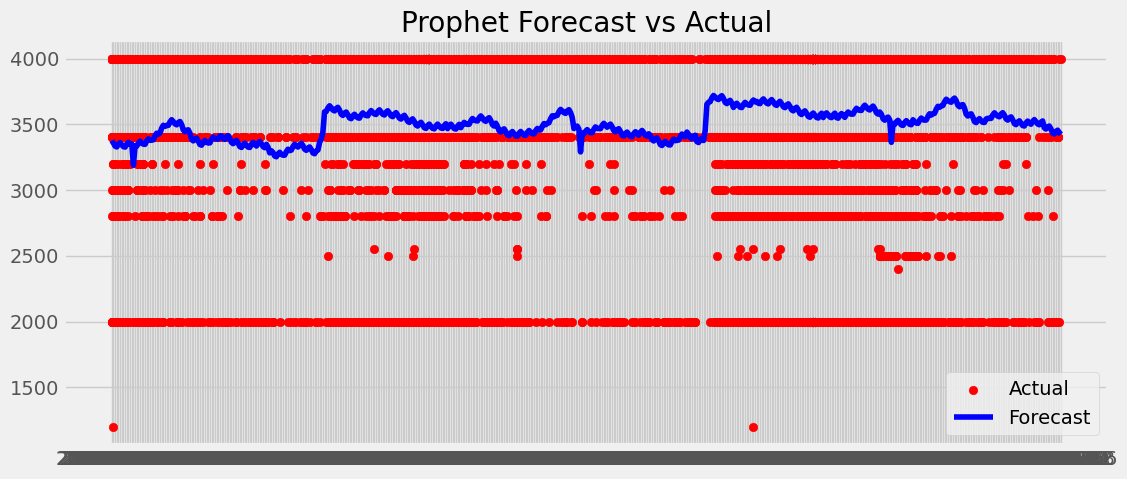

In [ ]:
# Plot actual vs forecasted values
fig, ax = plt.subplots(figsize=(12, 5))

# Plot actual values
ax.scatter(df_test.index, df_test['Amount'], color='r', label='Actual')

# Plot the forecast
ax.plot(df_test.index, df_test_fcst['yhat'], color='b', label='Forecast')

ax.set_title('Prophet Forecast vs Actual')
ax.legend()
plt.show()

#***Model Evaluation***

---



Evaluating the model's performance using various metrics:

In [ ]:
# Calculate Root Mean Squared Error (RMSE)
np.sqrt(mean_squared_error(y_true=df_test['Amount'],y_pred=df_test_fcst['yhat']))

771.6082994872637

In [ ]:
# Calculate Mean Absolute Error (MAE)
mean_absolute_error(y_true=df_test['Amount'],y_pred=df_test_fcst['yhat'])

617.8262446796178

In [ ]:
# Calculate Mean Absolute Percentage Error (MAPE)
mean_absolute_percentage_error(y_true=df_test['Amount'],y_pred=df_test_fcst['yhat'])

23.165560733038433

#***Future Forecast***

Extending the forecast to the next 5 years and visualizing:

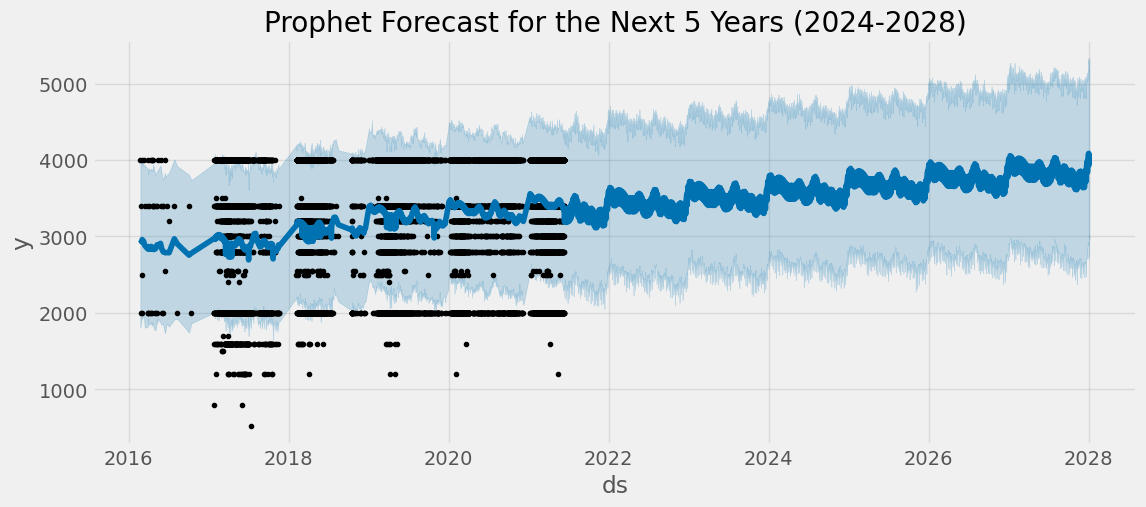

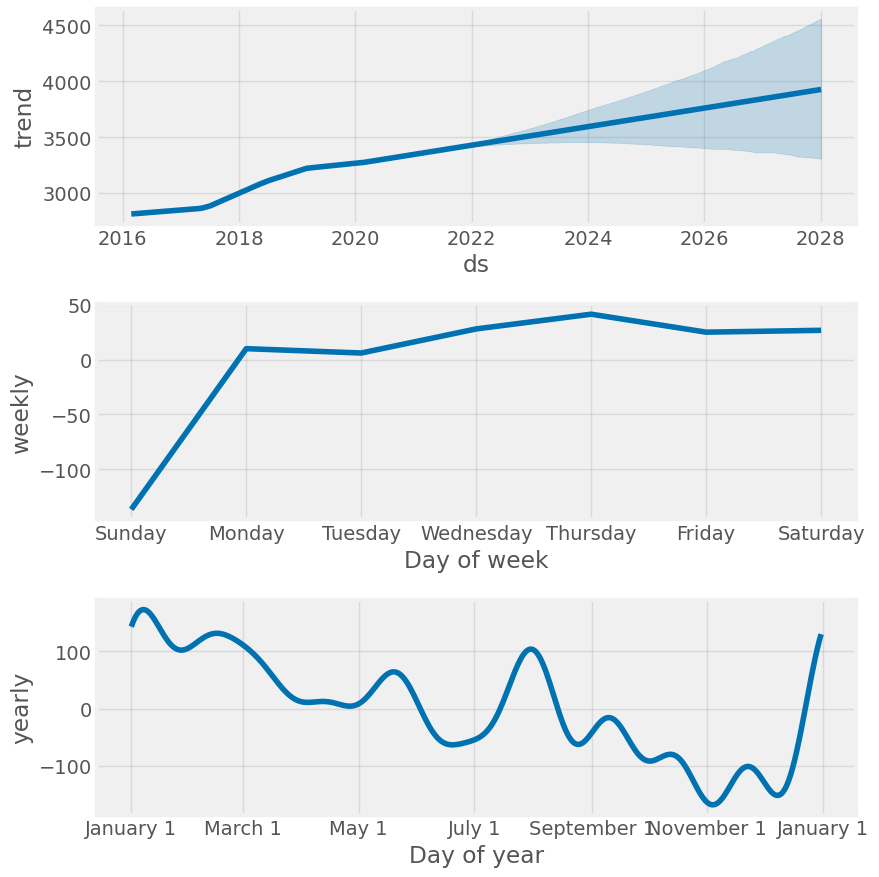

,ds,yhat,yhat_lower,yhat_upper
3398,2027-12-31,4073.893863,2868.664667,5266.312762
3399,2028-01-01,4087.172557,2919.593227,5253.034947
3400,2028-01-02,3934.169882,2718.970982,5094.535403
3401,2028-01-03,4089.247183,3027.690992,5333.828851
3402,2028-01-04,4092.371972,2963.689897,5294.441654


In [ ]:
# Extend the future DataFrame to the next 5 years (2024-2028)
future = model.make_future_dataframe(periods=2400)

# Make predictions for the future dates
forecast = model.predict(future)

# Plot the forecasted values
fig, ax = plt.subplots(figsize=(12, 5))
fig = model.plot(forecast, ax=ax)
ax.set_title('Prophet Forecast for the Next 5 Years (2024-2028)')
plt.show()

# Plot the forecast components
fig = model.plot_components(forecast)
plt.show()

# Display the forecasted values for the last few months of the forecast period
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
